## Graphs for the 48 min recording (ripple range)

In [7]:
import Ipynb_importer

In [10]:
import TrodesReader
from collections import deque
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
from pprint import pprint

In [11]:
def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    if filter_name == 'elliptical':
        sos = signal.ellip(order, 0.01, 120, [lowcut, highcut], btype='bp', output='sos', fs=sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

    y = signal.sosfiltfilt(sos, flattened_array)

    return y


def calculate_rms(buffer):
    square_summed = 0
    for k in buffer:
        square_summed += (k ** 2)

    return math.sqrt(square_summed / len(buffer))


def filter_then_rms(buffer, low_cut, high_cut, threshold):
    filtered_buffer = bandpass_filter('butterworth', buffer, lfp_sampling_rate, 1, low_cut, high_cut)
    current_rms = calculate_rms(filtered_buffer)
    return current_rms >= threshold

In [12]:
# this is the 48 min data
data_path = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt28ch1.dat'
time_path = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.timestamps.dat'

In [13]:
data = TrodesReader.readTrodesExtractedDataFile(data_path)
#pprint(data)

<string>:69: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [14]:
time = TrodesReader.readTrodesExtractedDataFile(time_path)
#pprint(time)

In [15]:
start_time = int(time['first_timestamp'])
time_data = []
for i in time['data']:
    time_data.append((i[0]-start_time)/30000)

In [16]:
# check the total recording length
print(time_data[len(time_data)-1]/60)

39.58271277777778


In [17]:
lfp_sampling_rate = 1500
lfp_sampling_period = (1/lfp_sampling_rate)*(10**9)

#lower_bound = 10000
#upper_bound = 19000
sw_lower = 5
sw_upper = 15
ripple_lower = 150
ripple_upper = 250
num_std = 4

In [18]:
all_data = data['data']
lfp_data = []
for i in all_data:
    lfp_data.append(i[0])

ripple_lfp_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
sw_lfp_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, sw_lower, sw_upper)

<IPython.core.display.Javascript object>


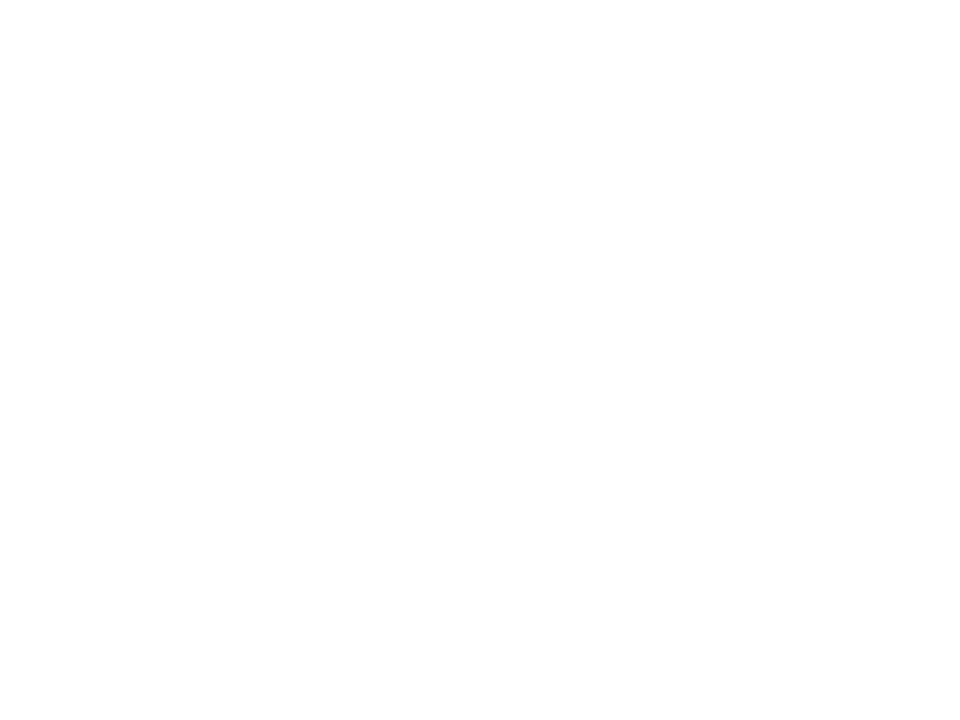

In [19]:
%matplotlib notebook
fig1 = plt.figure()
plt.plot(time_data,sw_lfp_data)
plt.plot(time_data,ripple_lfp_data)
plt.xlabel('Time(s)')
plt.ylabel('Power(µV)')
plt.show()

In [20]:
print(len(time_data))
print(len(lfp_data))
print(time_data[-1])

3562445
3562445
2374.9627666666665


In [21]:
offline_rms = []
offline_time = []
ripple250 = []
rawlfp = []
for i in range(2360000, 2782000):
    raw_buffer = lfp_data[i-150:i]
    current_buffer = ripple_lfp_data[i-150:i]
    current_rms = calculate_rms(current_buffer)
    offline_rms.append(current_rms)
    offline_time.append(time_data[i])
#     if(current_rms<=250):
#         offline_rms.append(current_rms)
#         offline_time.append(time_data[i])
#         ripple250.append(current_buffer)
#         rawlfp.append(raw_buffer)

In [22]:
print(len(offline_rms),len(offline_time),len(ripple250),len(rawlfp))

422000 422000 0 0


In [23]:
online_rms = []
online_time = []
onlineripple250 = []
for i in range(2360000, 2782000):
    current_buffer = lfp_data[i-150:i]
    current_filtered = bandpass_filter('butterworth', current_buffer, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
    current_rms = calculate_rms(current_filtered)
    online_rms.append(current_rms)
    online_time.append(time_data[i])
#     if(current_rms<=250):
#         online_rms.append(current_rms)
#         online_time.append(time_data[i])
#         onlineripple250.append(current_filtered)

In [24]:
avg_offline = np.mean(offline_rms)
std_offline = np.std(offline_rms)
threshold_offline = avg_offline + num_std*std_offline
print(avg_offline)
print(std_offline)
print(threshold_offline)

35.60290432183957
25.597201471035877
137.99171020598308


In [25]:
avg_online = np.mean(online_rms)
std_online = np.std(online_rms)
threshold_online = avg_online + num_std*std_online
print(avg_online)
print(std_online)
print(threshold_online)

35.2554257213291
25.413080950314328
136.9077495225864


<IPython.core.display.Javascript object>


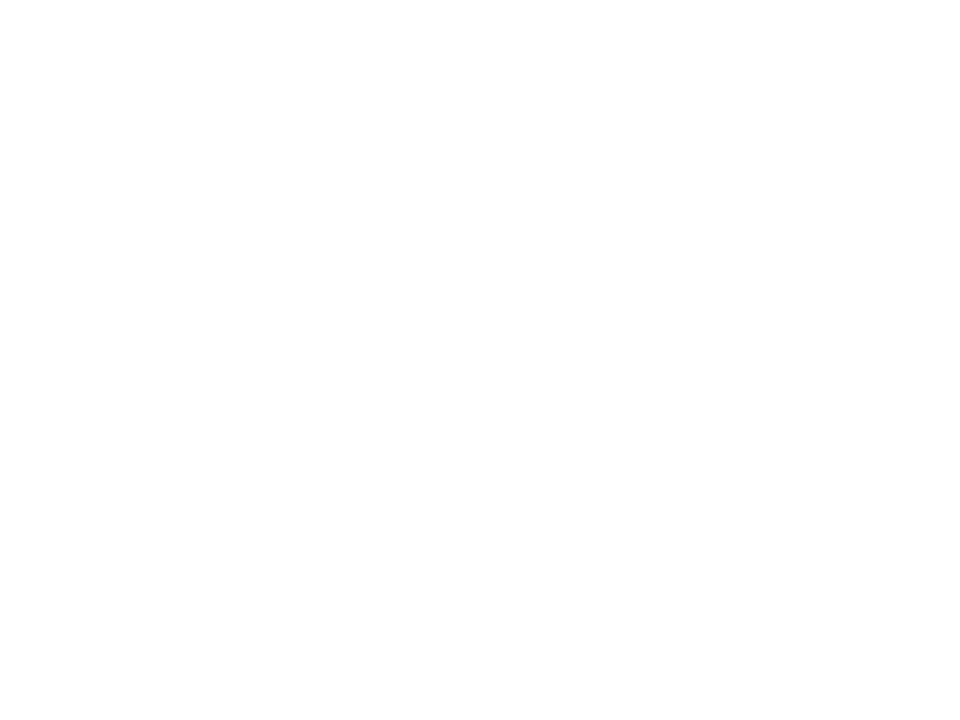

In [26]:
fi2 = plt.figure()
plt.plot(online_time, online_rms)
plt.plot(offline_time, offline_rms)
plt.axhline(y=threshold_online)
plt.axhline(y=threshold_offline)
plt.show()

In [27]:
zscore_online = []

for i in range(0,len(online_rms)):
    zscore_online.append((online_rms[i]-avg_online)/std_online)

In [28]:
zscore_offline = []

for i in range(0,len(offline_rms)):
    zscore_offline.append((offline_rms[i]-avg_offline)/std_offline)

<IPython.core.display.Javascript object>


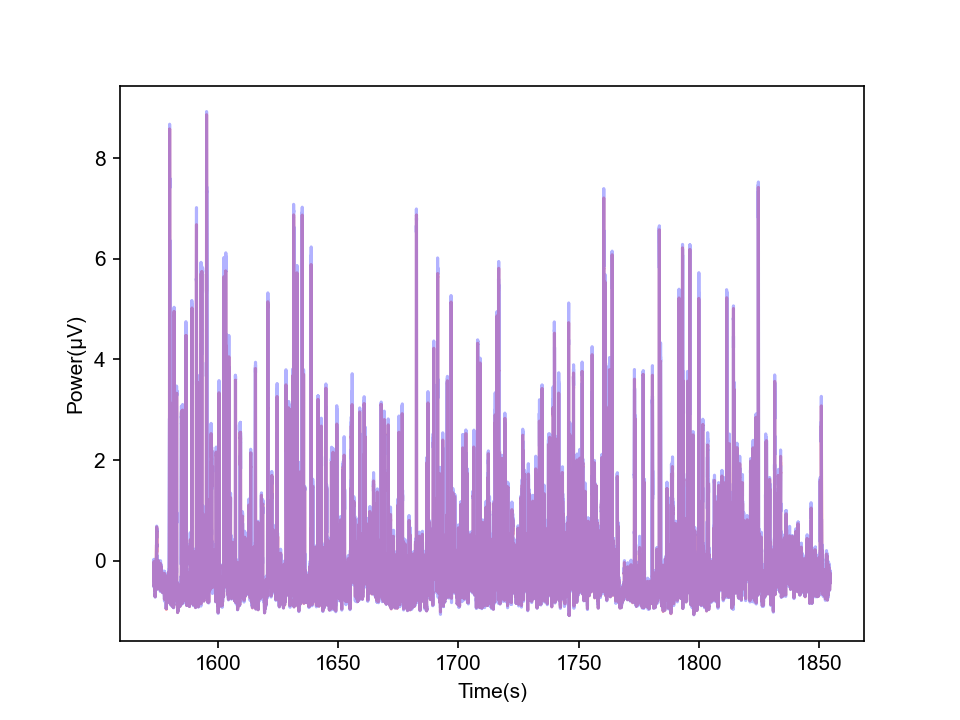

In [29]:
%matplotlib notebook
fig3 = plt.figure()
plt.plot(offline_time, zscore_offline,color='r',alpha=0.3)
plt.plot(online_time, zscore_online,color='b',alpha=0.3)
plt.xlabel('Time(s)')
plt.ylabel('Power(µV)')
plt.show()

In [30]:
online_decision = [False, False]
online_stimulation = []

for i in range(0,len(online_rms)):
    online_decision.append(online_rms[i]>threshold_online)
    current_stimulation = True
    for m in range(len(online_decision)-3,len(online_decision)):
        if not online_decision[m]:
            current_stimulation = False
    online_stimulation.append(current_stimulation)    

In [31]:
offline_decision = [False, False]
offline_stimulation = []

for i in range(0,len(offline_rms)):
    offline_decision.append(offline_rms[i]>threshold_offline)
    current_stimulation = True
    for m in range(len(offline_decision)-3,len(offline_decision)):
        if not offline_decision[m]:
            current_stimulation = False
    offline_stimulation.append(current_stimulation) 

In [32]:
online_decision.pop(0)
online_decision.pop(0)

False

<IPython.core.display.Javascript object>


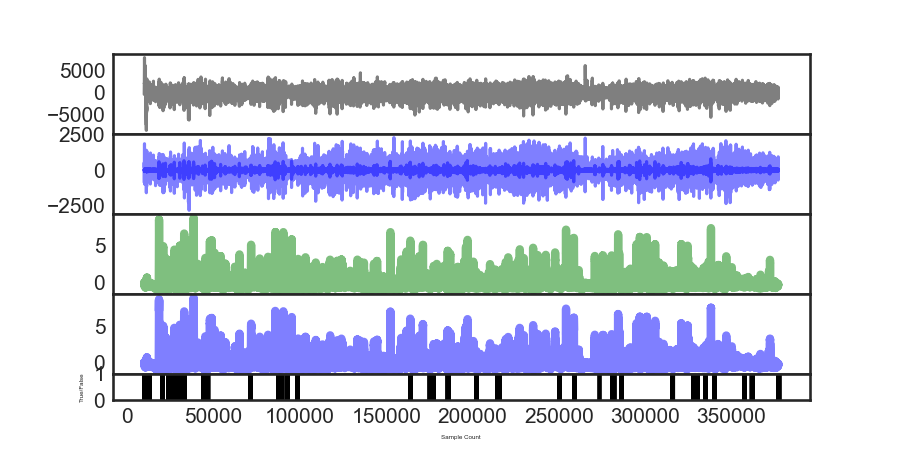

In [33]:
fig4 = plt.figure(figsize=(6, 3))
plt.style.use("seaborn-white")
grid1 = plt.GridSpec(13, 1, wspace=0, hspace=0)
ax1 = plt.subplot(grid1[0:3, 0:1])
ax2 = plt.subplot(grid1[3:6, 0:1])
ax3 = plt.subplot(grid1[6:9, 0:1])
ax4 = plt.subplot(grid1[9:12, 0:1])
ax5 = plt.subplot(grid1[12, 0:1])

ax1.plot(lfp_data[2360000:2782000], color='k', alpha=0.5, label='Raw LFP')
# ax1.set_ylabel("Power(µV)", fontsize=30)
# ax1.legend(fontsize=30)

ax2.plot(ripple_lfp_data[2360000:2782000], color='b', alpha=0.5, label='Ripple Band')
ax2.plot(sw_lfp_data[2360000:2782000], color='b', alpha=0.5, label='Sharp Wave Band')
# ax2.set_ylabel("Power(µV)", fontsize=30)
# ax2.legend(fontsize=30)

ax3.plot(zscore_offline, color='g', linewidth='4', alpha=0.5, label='Offline Z-scored RMS')
# ax3.set_ylabel("Z Score", fontsize=30)
# ax3.legend(fontsize=30)

ax4.plot(zscore_online, color='b', linewidth='4', alpha=0.5, label='Online Z-scored RMS')
# ax4.set_ylabel("Z Score", fontsize=30)
# ax4.legend(fontsize=30)

for s in range(0,len(online_stimulation)):
    if online_stimulation[s]:
        ax5.axvline(x=s, color='k')
        
ax5.set_ylabel("True/False", fontsize=3)
#ax5.legend(['Stimulation Status'], fontsize=30)
ax5.set_xlabel('Sample Count', fontsize=3)

plt.show()

In [34]:
onlineStimArr = np.array(online_stimulation)
print(type(onlineStimArr), type(online_stimulation))

<class 'numpy.ndarray'> <class 'list'>


<IPython.core.display.Javascript object>


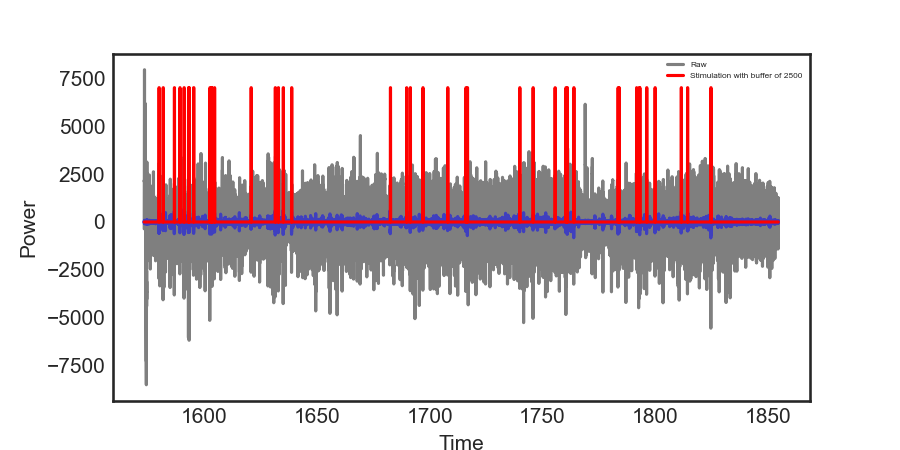

In [35]:
# lfp_data[2360000:2782000]
plt.figure(figsize=(6, 3))
plt.plot(online_time, lfp_data[2360000:2782000], color='k', alpha=0.5, label='Raw')
plt.plot(online_time, ripple_lfp_data[2360000:2782000], color='b', alpha=0.5)
plt.plot(online_time, onlineStimArr *7000,color='r', label = 'Stimulation with buffer of 2500')
plt.legend(fontsize=4)
plt.xlabel('Time')
plt.ylabel('Power')

# for s in range(0,len(online_stimulation)):
#     if online_stimulation[s]:
#         ax1.axvline(x=s, color='k')
        
plt.show()

In [36]:
onlineStimArr = np.array(online_stimulation)
print(type(onlineStimArr), type(online_stimulation))

<class 'numpy.ndarray'> <class 'list'>


<IPython.core.display.Javascript object>


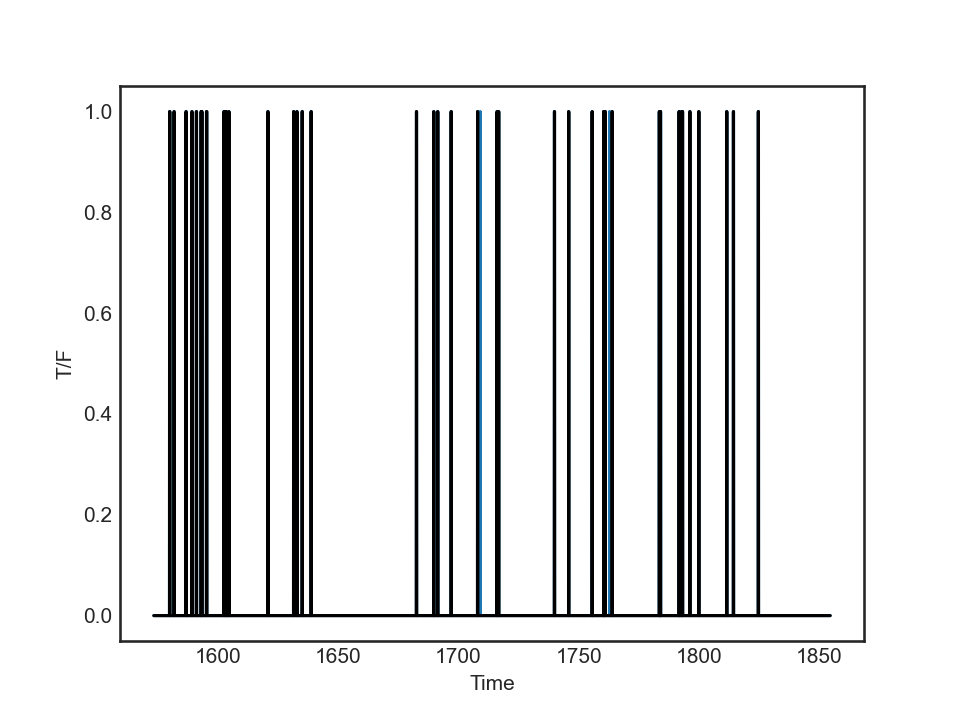

In [37]:
plt.figure()
plt.plot(online_time, online_decision)
plt.plot(online_time, online_stimulation, color='k')
plt.xlabel('Time')
plt.ylabel('T/F')
plt.show()

<IPython.core.display.Javascript object>


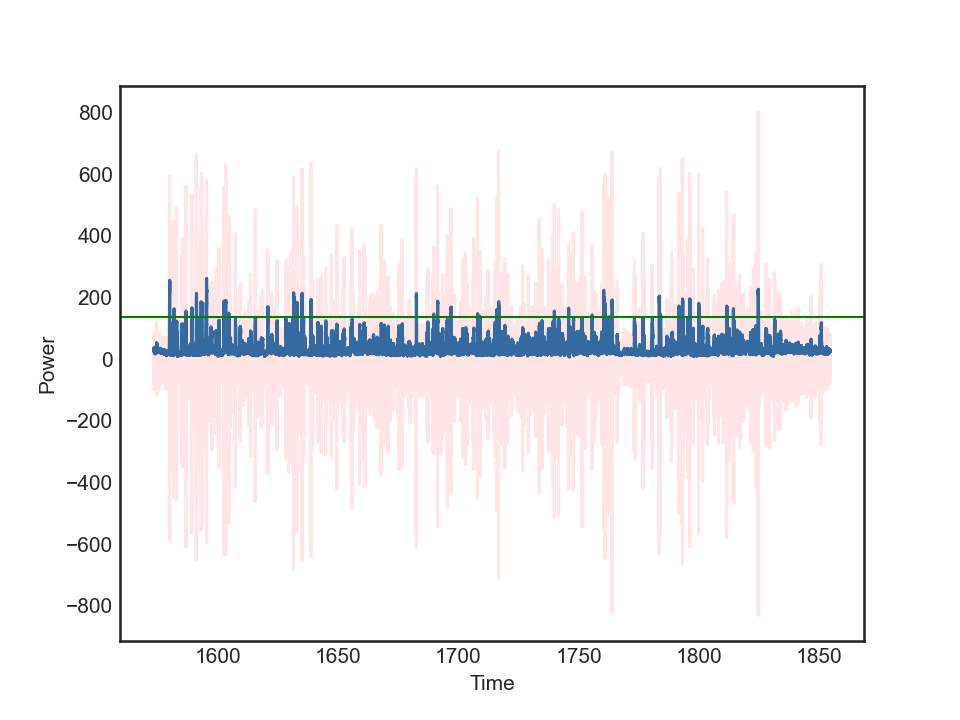

In [38]:
plt.figure()
plt.plot(online_time,online_rms)
plt.plot(online_time,ripple_lfp_data[2360000:2782000], color='r',alpha=0.1)
plt.axhline(y=threshold_online, color='green',linewidth = '1',label='Threshold')
plt.xlabel('Time')
plt.ylabel('Power')
plt.show()

# Accuracy, Precision, Recall

In [39]:
TP = 0
FP = 0
TN = 0
FN = 0
for i in range(len(online_stimulation)):
    if offline_stimulation[i] == True and online_stimulation[i] == True:
        TP += 1
    if offline_stimulation[i] == False and online_stimulation[i] == False:
        TN += 1    
    if offline_stimulation[i] == False and online_stimulation[i] == True:
        FP += 1
    if offline_stimulation[i] == True and online_stimulation[i] == False:
        FN += 1
TP,TN,FP,FN      

(5032, 416667, 56, 245)

In [40]:
Accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
print("A:",Accuracy)
Precision = TP/(TP+FP) *100
print("P:",Precision)
Recall = (TP/(TP+FN))*100
print("R:",Recall)

A: 99.92867298578199
P: 98.89937106918238
R: 95.35721053628956


In [41]:
Values = [Accuracy,Precision,Recall]
Labels=['Accuracy','Precision','Recall']

<IPython.core.display.Javascript object>


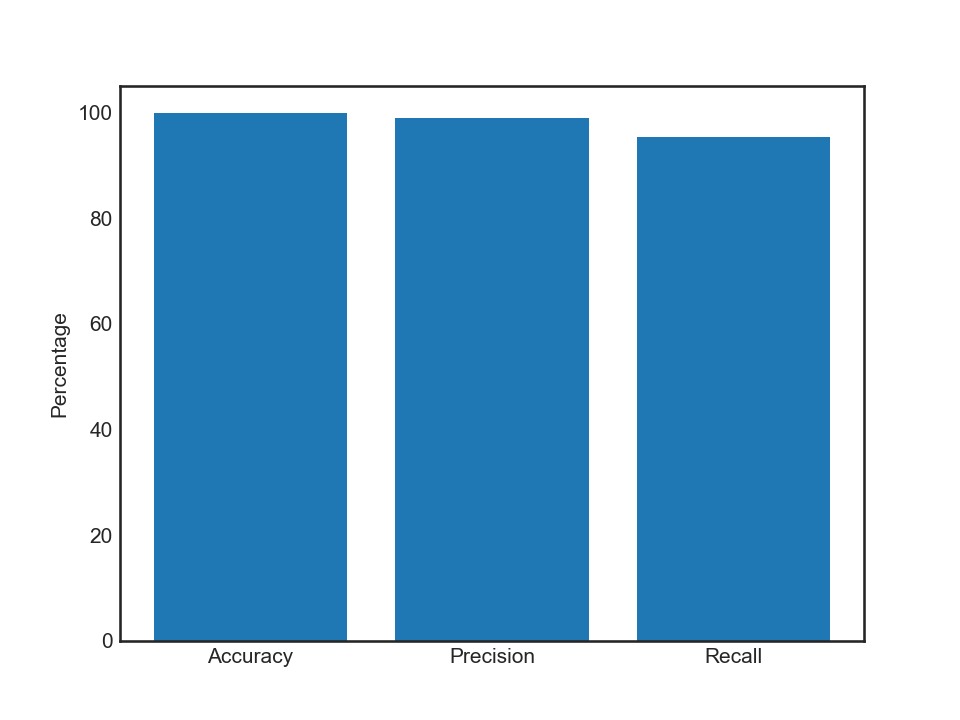

<function matplotlib.pyplot.show(block=None)>

In [42]:
plt.figure()
plt.bar(Labels,Values)
plt.ylabel('Percentage')
plt.show

# Testing

In [43]:
# offline_rms = []
# offline_time = []
# offlineripple250 = []
# rawlfp = []
# for i in range(2360000, 2782000):
#     raw_buffer = lfp_data[i-150:i]
#     current_buffer = ripple_lfp_data[i-150:i]
#     current_rms = calculate_rms(current_buffer)
#     if(current_rms<=250):
#         offline_rms.append(current_rms)
#         offline_time.append(time_data[i])
#         offlineripple250.append(current_buffer)
#         rawlfp.append(raw_buffer)

In [44]:
# online_rms = []
# online_time = []
# online_time_2 = []
# onlineripple250 = []
# for i in range(2360000, 2782000):
#     current_buffer = lfp_data[i-150:i]
#     current_filtered = bandpass_filter('butterworth', current_buffer, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
#     current_rms = calculate_rms(current_filtered)
#     online_time_2.append(time_data)
#     if(current_rms<=250):
#         online_rms.append(current_rms)
#         online_time.append(time_data[i])
#         onlineripple250.append(current_filtered)

In [45]:
# avg_online = np.mean(online_rms)
# std_online = np.std(online_rms)
# threshold_online = avg_online + num_std*std_online
# print(avg_online)
# print(std_online)
# print(threshold_online)

In [46]:
# avg_offline = np.mean(offline_rms)
# std_offline = np.std(offline_rms)
# threshold_offline = avg_offline + num_std*std_offline
# print(avg_offline)
# print(std_offline)
# print(threshold_offline)

In [47]:
# zscore_online = []

# for i in range(0,len(online_rms)):
#     zscore_online.append((online_rms[i]-avg_online)/std_online)
    
# zscore_offline = []

# for i in range(0,len(offline_rms)):
#     zscore_offline.append((offline_rms[i]-avg_offline)/std_offline)

In [48]:
# online_decision = [False, False]
# online_stimulation = []

# for i in range(0,len(online_rms)):
#     online_decision.append(online_rms[i]>threshold_online)
#     current_stimulation = True
#     for m in range(len(online_decision)-3,len(online_decision)):
#         if not online_decision[m]:
#             current_stimulation = False
#     online_stimulation.append(current_stimulation) 

In [49]:
# online_decision.pop(0)
# online_decision.pop(0)

In [50]:
# plt.figure()
# plt.plot(online_time,online_rms,color='k',alpha=1)
# plt.plot(online_time_2,ripple_lfp_data[2360000:2782000], color='r',alpha=0.1)
# plt.axhline(y=threshold_offline, color='green',linewidth = '1',label='Threshold')
# plt.xlabel('Time')
# plt.ylabel('Power')
# plt.show()

In [51]:
# print(len(ripple_lfp_data[2360000:2782000]),len(offlineripple250))